In [388]:
import numpy as np 
import glob 
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve, calculate_3d_curve_abscissas,remove_high_freq_components
from AngioMorphPCA.io import Get_simple_vtk, makeVtkFile, mkdir
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from AngioMorphPCA.compute_geometry import compute_curvature_and_torsion,build_curve_from_curvatures
from tqdm import tqdm
import matplotlib.pyplot as plt
from geomstats.learning.frechet_mean import FrechetMean
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)
from geomstats.learning.pca import TangentPCA
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
from scipy.stats import linregress
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

import seaborn as sns
sns.set_theme(style="white", color_codes=True)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


print (glob.glob("../geom_aligned_curves/*.npy"))
# curve_bs = np.array(curve_bs)
curve_bs = np.load("../geom_aligned_curves/geomstats_aligned_to_first.npy")
curve_cs = np.load("../geom_aligned_curves/geomstats_aligned_to_frechet.npy")
unaligned_curvatures = np.load("../unaligned_curvatures.npy")
files = np.load("../geom_aligned_curves/total_files_with_a.npy")[:curve_bs.shape[0]]

print (curve_bs.shape)
print (curve_cs.shape)
print (unaligned_curvatures.shape)
print (files.shape)

brava_num = 79

k_sampling_points = 120

curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=k_sampling_points, equip=False
)

curves_r3.equip_with_metric(SRVMetric)

mean = FrechetMean(curves_r3)
mean.fit(curve_cs)

mean_estimate = mean.estimate_

tangent_base = mean.estimate_

['../geom_aligned_curves\\curvatures.npy', '../geom_aligned_curves\\geomstats_aligned_to_first.npy', '../geom_aligned_curves\\geomstats_aligned_to_first_with_a.npy', '../geom_aligned_curves\\geomstats_aligned_to_frechet.npy', '../geom_aligned_curves\\geomstats_aligned_to_frechet_with_a.npy', '../geom_aligned_curves\\total_files_with_a.npy']
(79, 119, 3)
(79, 119, 3)
(79, 120)
(79,)


- The first curve is not aligned in `curve_bs`.
- `curve_bs` and `curve_cs` have the same parameterization.

(79, 119, 3)


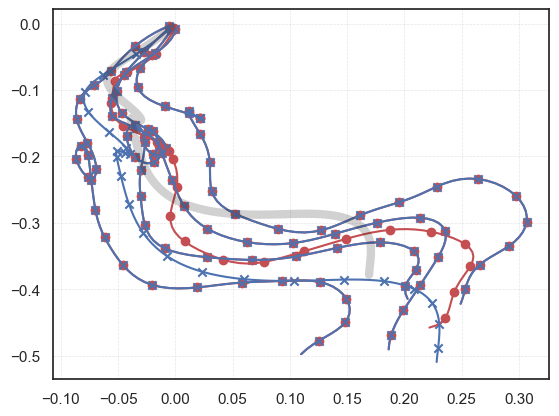

In [389]:
print (curve_bs.shape)
for i in range(5):
    plt.plot(curve_bs[i,:,0],curve_bs[i,:,1],c='r')
    plt.plot(curve_cs[i,:,0],curve_cs[i,:,1],c='b')
    plt.scatter(curve_bs[i,::5,0],curve_bs[i,::5,1],c='r')
    plt.scatter(curve_cs[i,::5,0],curve_cs[i,::5,1],c='b',marker='x')
plt.plot(mean_estimate[:,0],mean_estimate[:,1],c='k', linewidth=6, alpha=0.2)
plt.grid(linewidth=0.5, linestyle='--', alpha=0.5)
plt.show()

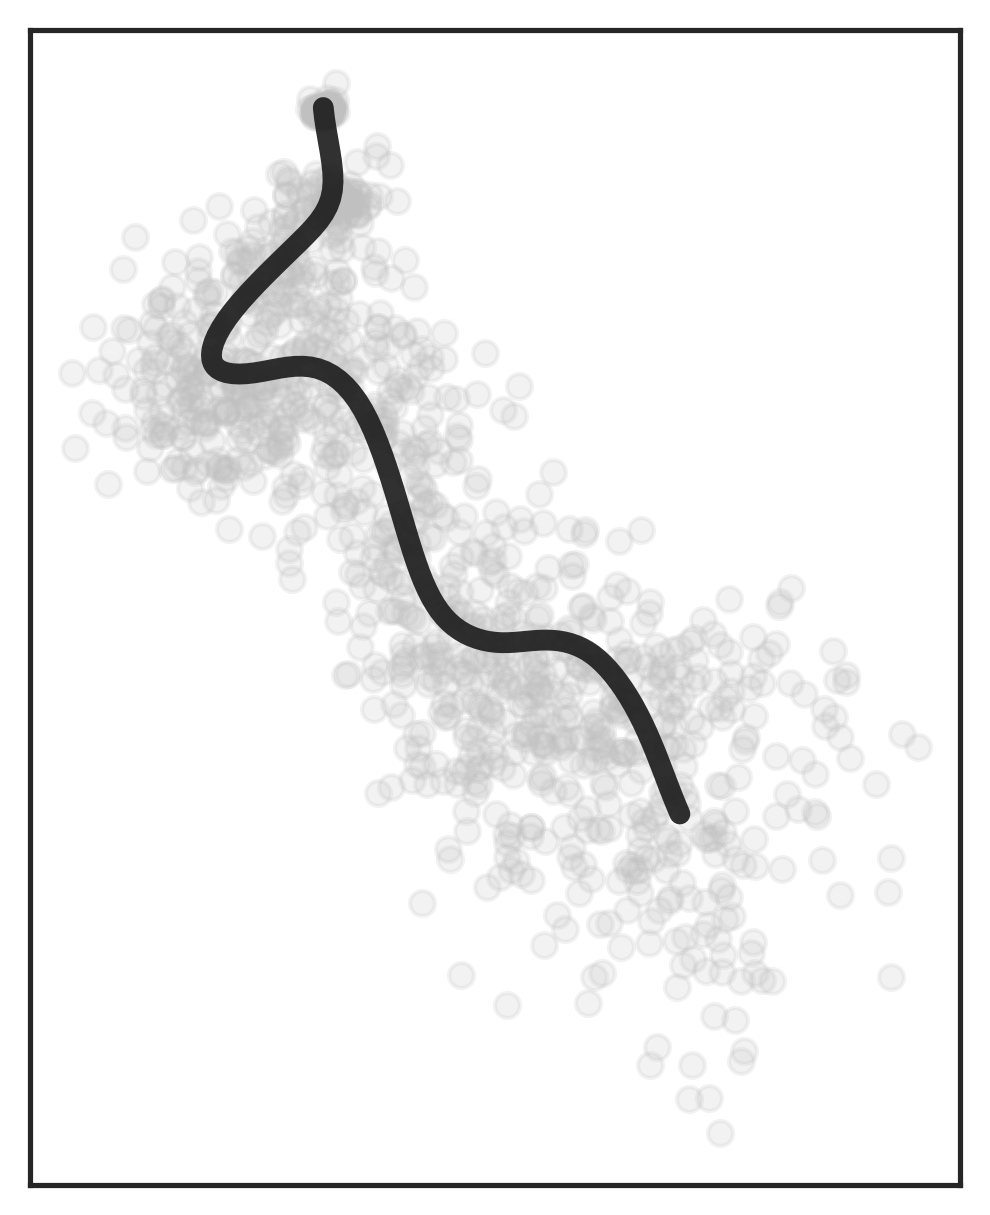

In [390]:
fig = plt.figure(dpi=300, figsize=(4, 5))
ax = fig.add_subplot(111)
for i in range(curve_bs.shape[0]):
    ax.scatter(curve_cs[i,::8,2],curve_cs[i,::8,1], color="silver", alpha=0.2)
    # plt.scatter(curve_cs[i,::6,0],curve_cs[i,::6,1],c='b',marker='o', alpha=0.7)
ax.plot(mean_estimate[:,2],mean_estimate[:,1],c='k', linewidth=5, alpha=0.9)
# ax.grid(linewidth=0.5, linestyle='--', alpha=0.5)
ax.autoscale()
ax.set_xticks([])
ax.set_yticks([])

plt.show()

d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)


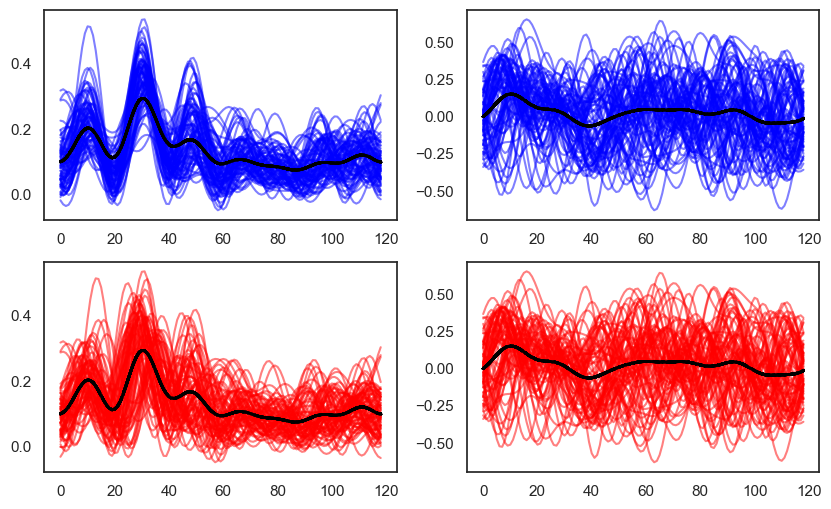

In [391]:
import numpy as np
import matplotlib.gridspec as gridspec

def compute_tortuosity(curve):
    """
    计算曲线的扭曲度
    """
    # 计算曲线的长度
    curve_length = np.sum(np.linalg.norm(np.diff(curve, axis=0), axis=1))
    # 计算曲线的欧式距离
    euclidean_distance = np.linalg.norm(curve[-1] - curve[0])
    # 计算扭曲度
    tortuosity = curve_length / euclidean_distance
    return tortuosity

def autocovariance_function(curvatures):
    """
    Compute the sample autocovariance function for a set of curvature profiles.

    Parameters:
    - curvatures: A (k, n) numpy array where k is the number of curvature profiles and
                  n is the number of points in each profile.

    Returns:
    - A (n, n) numpy array containing the sample autocovariance values for the curvature
      profiles at each pair of points.
    """
    k, n = curvatures.shape
    # Compute the mean curvature at each point across the k profiles
    mean_curvatures = np.mean(curvatures, axis=0)
    
    # Initialize an n x n matrix to store the autocovariance values
    autocovariance = np.zeros((n, n))
    
    # Calculate the sample autocovariance for each pair of points (t, s)
    for t in range(n):
        for s in range(n):
            sum_cov = np.sum((curvatures[:, t] - mean_curvatures[t]) * (curvatures[:, s] - mean_curvatures[s]))
            autocovariance[t, s] = sum_cov / (k - 1)
    
    return np.array(autocovariance)

def polynomial_fit(curvature, degree=3):
    """
    Fit a polynomial to the curvature data and return the fitted curve.

    Parameters:
    - curvature: A list or numpy array containing the curvature data.
    - degree: The degree of the polynomial function to fit.

    Returns:
    - A numpy array containing the fitted polynomial curve.
    """
    # Generate x values based on the length of the curvature data
    x_values = np.arange(len(curvature))
    
    # Fit the polynomial of the given degree to the curvature data
    coeffs = np.polyfit(x_values, curvature, degree)
    
    # Create a polynomial function from the coefficients
    poly_func = np.poly1d(coeffs)
    
    # Generate the fitted curve
    fitted_curve = poly_func(x_values)
    
    return fitted_curve,coeffs

curvatures = []
torsions = []

for i in range(len(curve_cs)):
    c,t = compute_curvature_and_torsion(curve_cs[i]*100)
    fft_c = remove_high_freq_components(c,0.06)
    fft_t = remove_high_freq_components(t,0.06)
    curvatures.append(fft_c)
    torsions.append(fft_t)
curvatures = np.array(curvatures)
torsions = np.array(torsions)

from scipy.signal import correlate

# 函数以计算相位差并对齐数据
def align_curves(data, reference):
    aligned_data = np.zeros_like(data)
    phase_shifts = np.zeros(data.shape[0], dtype=int)
    
    for i, curve in enumerate(data):
        # 计算互相关
        correlation = correlate(curve, reference, mode='full')
        # 找到互相关最大值的位置
        shift = correlation.argmax() - (len(reference) - 1)
        # 计算相位差
        phase_shifts[i] = shift
        # 对齐曲线
        aligned_data[i] = np.roll(curve, -shift)
    
    return aligned_data, phase_shifts

def restore_original_data(aligned_data, phase_shifts):
    original_data = np.zeros_like(aligned_data)
    
    for i, (curve, shift) in enumerate(zip(aligned_data, phase_shifts)):
        # 使用相反的平移量恢复原始数据
        original_data[i] = np.roll(curve, shift)
    
    return original_data

def apply_phase_shifts(data, phase_shifts):
    aligned_data = np.zeros_like(data)
    
    for i, (curve, shift) in enumerate(zip(data, phase_shifts)):
        # 根据相位差平移曲线
        aligned_data[i] = np.roll(curve, -shift)
    
    return aligned_data

def compute_amplitude_factors(data, mean_curve, phase_shifts):
    amplitude_factors = np.zeros(data.shape[0])
    
    for i, (curve, shift) in enumerate(zip(data, phase_shifts)):
        # 将平均曲线根据相位差进行平移
        shifted_mean_curve = np.roll(mean_curve, shift)
        # 通过最小化均方误差计算振幅因子
        if np.linalg.norm(shifted_mean_curve) != 0:
            amplitude_factors[i] = np.dot(curve, shifted_mean_curve) / np.dot(shifted_mean_curve, shifted_mean_curve)
    
    return amplitude_factors

def reconstruct_data_with_amplitude(mean_curve, phase_shifts, amplitude_factors):
    reconstructed_data = np.zeros((len(phase_shifts), len(mean_curve)))
    
    for i, (shift, amplitude) in enumerate(zip(phase_shifts, amplitude_factors)):
        # 调整平均曲线的振幅和相位
        reconstructed_data[i] = amplitude * np.roll(mean_curve, shift)
    
    return reconstructed_data




# 使用函数应用相位差
# applied_aligned_data = apply_phase_shifts(data, phase_shifts)


# 对数据进行对齐
# data = curvatures.copy()
mean_curve = np.mean(curvatures, axis=0)
old_curvatures = curvatures.copy()
old_torsions = torsions.copy()
curvatures, phase_shifts = align_curves(curvatures, mean_curve)
# 计算振幅因子
amplitude_factors = compute_amplitude_factors(curvatures, mean_curve, phase_shifts)

fig = plt.figure(figsize=(10, 6), dpi=100)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
for i in range(len(aligned_data)):
    ax1.plot(curvatures[i], alpha=0.5, color='blue')
    ax1.plot(mean_curve, color='black', linewidth=2)
    ax2.plot(torsions[i], alpha=0.5, color='blue')
    ax2.plot(np.mean(torsions, axis=0), color='black', linewidth=2)
    ax3.plot(old_curvatures[i], alpha=0.5, color='red')
    ax3.plot(np.mean(old_curvatures, axis=0), color='black', linewidth=2)
    ax4.plot(old_torsions[i], alpha=0.5, color='red')
    ax4.plot(np.mean(old_torsions, axis=0), color='black', linewidth=2)

torsions = apply_phase_shifts(torsions, phase_shifts)
# # 使用函数还原原始数据
# restored_data = restore_original_data(aligned_data, phase_shifts)

# # 验证还原的数据是否与原始数据相同
# np.allclose(restored_data, data)

Reconstruction error: 0.06


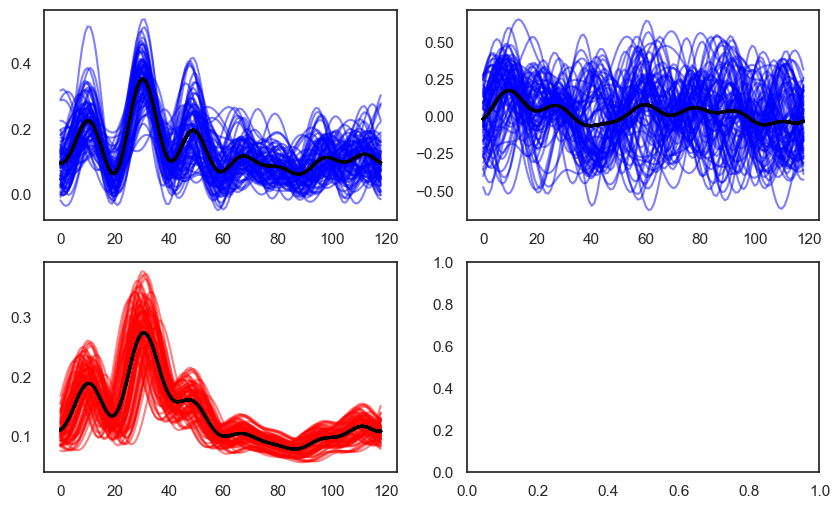

In [392]:
# print (amplitude_factors)

# 使用振幅和相位重建数据
reconstructed_data = reconstruct_data_with_amplitude(mean_curve, phase_shifts, amplitude_factors)

# 计算重建数据与原始数据之间的平均绝对误差
reconstruction_error = np.mean(np.abs(reconstructed_data - data))

# 显示重建误差
print(f'Reconstruction error: {reconstruction_error:.2f}')


fig = plt.figure(figsize=(10, 6), dpi=100)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
for i in range(len(curvatures)):
    ax1.plot(curvatures[i], alpha=0.5, color='blue')
    ax1.plot(np.mean(curvatures, axis=0), color='black', linewidth=2)
    ax2.plot(torsions[i], alpha=0.5, color='blue')
    ax2.plot(np.mean(torsions, axis=0), color='black', linewidth=2)
    ax3.plot(reconstructed_data[i], alpha=0.5, color='red')
    ax3.plot(np.mean(reconstructed_data, axis=0), color='black', linewidth=2)

torsions = apply_phase_shifts(torsions, phase_shifts)
# # 使用函数还原原始数据
# restored_data = restore_original_data(aligned_data, phase_shifts)

# # 验证还原的数据是否与原始数据相同
# np.allclose(restored_data, data)



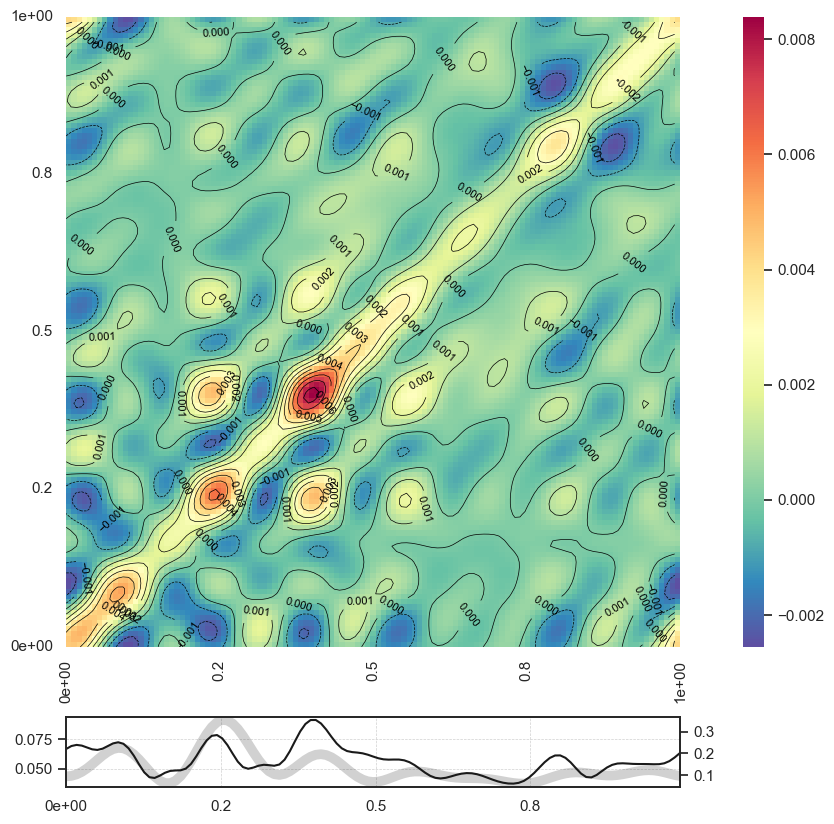

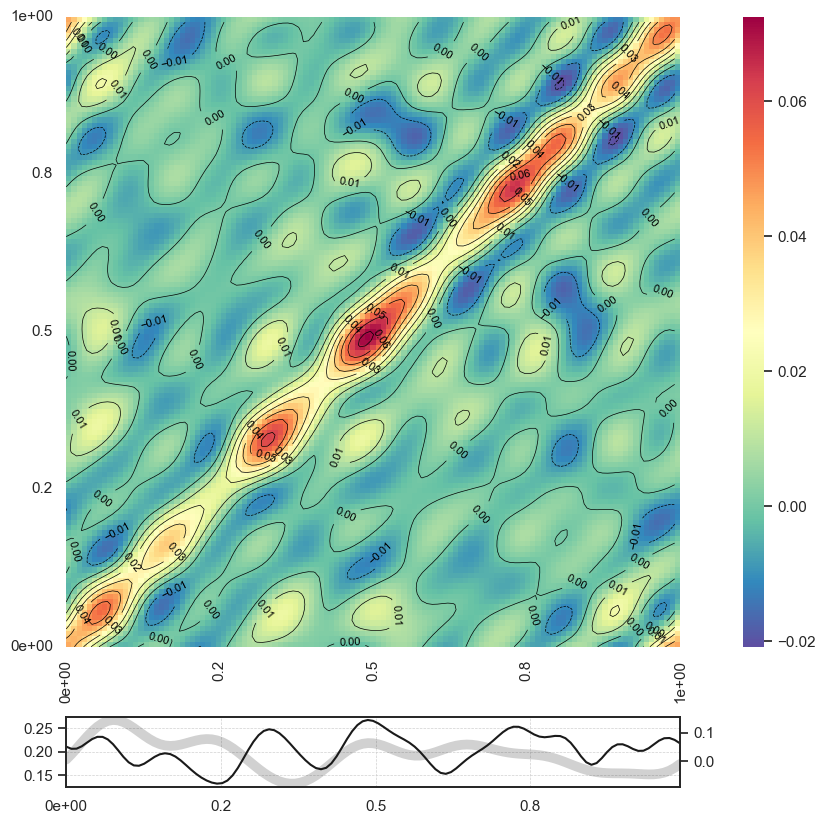

In [393]:
fig = plt.figure(figsize=(9, 10), dpi=100)
gs = gridspec.GridSpec(2, 2, height_ratios=[9, 1], width_ratios=[30, 1])
# The first subplot (standard deviation line plot).
ax1 = fig.add_subplot(gs[0, 0])  # First row, first column
ax2 = fig.add_subplot(gs[1, 0])  # Second row, first column
cbar_ax = fig.add_subplot(gs[0, 1])  # Span both rows, second column

std_deviation = np.std(curvatures, axis=0)
autocovariance_values = autocovariance_function(curvatures)
sns.heatmap(autocovariance_values, cmap='Spectral_r', ax=ax1, cbar_ax=cbar_ax)
CS = ax1.contour(autocovariance_values, colors='black', levels=10, linewidths=0.5)

ax2.plot(std_deviation, 'k')  # 'k' is the color black for the line plot

ax3 = ax2.twinx()
ax3.plot(np.mean(curvatures, axis=0), 'k', alpha=0.2, linewidth=7)
ax2.grid(linewidth=0.5, linestyle='--', alpha=0.9)
# Adding contour labels
ax1.clabel(CS, inline=True, fontsize=8)
ax1.invert_yaxis()


ax1.set_xticks(np.linspace(0, len(autocovariance_values), num=5))  # 在0到199之间平均放置5个刻度
# 设置横轴的刻度标签，将其转换为百分比
ax1.set_xticklabels(['{:.0}'.format(x) for x in np.linspace(0, 1, num=5)])
ax1.set_yticks(np.linspace(0, len(autocovariance_values), num=5))  # 在0到199之间平均放置5个刻度
# 设置横轴的刻度标签，将其转换为百分比
ax1.set_yticklabels(['{:.0}'.format(x) for x in np.linspace(0, 1, num=5)])
ax2.set_xticks(np.linspace(0, len(autocovariance_values), num=5))  # 在0到199之间平均放置5个刻度
# 设置横轴的刻度标签，将其转换为百分比
ax2.set_xticklabels(['{:.0}'.format(x) for x in np.linspace(0, 1, num=5)])
ax2.autoscale(enable=True, axis='x', tight=True)
plt.show()




fig = plt.figure(figsize=(9, 10), dpi=100)
gs = gridspec.GridSpec(2, 2, height_ratios=[9, 1], width_ratios=[30, 1])
# The first subplot (standard deviation line plot).
ax1 = fig.add_subplot(gs[0, 0])  # First row, first column
ax2 = fig.add_subplot(gs[1, 0])  # Second row, first column
cbar_ax = fig.add_subplot(gs[0, 1])  # Span both rows, second column

std_deviation = np.std(torsions, axis=0)
autocovariance_values = autocovariance_function(torsions)
sns.heatmap(autocovariance_values, cmap='Spectral_r', ax=ax1, cbar_ax=cbar_ax)
CS = ax1.contour(autocovariance_values, colors='black', levels=10, linewidths=0.5)

ax2.plot(std_deviation, 'k')  # 'k' is the color black for the line plot

ax3 = ax2.twinx()
ax3.plot(np.mean(torsions, axis=0), 'k', alpha=0.2, linewidth=7)
ax2.grid(linewidth=0.5, linestyle='--', alpha=0.9)
# Adding contour labels
ax1.clabel(CS, inline=True, fontsize=8)
ax1.invert_yaxis()


ax1.set_xticks(np.linspace(0, len(autocovariance_values), num=5))  # 在0到199之间平均放置5个刻度
# 设置横轴的刻度标签，将其转换为百分比
ax1.set_xticklabels(['{:.0}'.format(x) for x in np.linspace(0, 1, num=5)])
ax1.set_yticks(np.linspace(0, len(autocovariance_values), num=5))  # 在0到199之间平均放置5个刻度
# 设置横轴的刻度标签，将其转换为百分比
ax1.set_yticklabels(['{:.0}'.format(x) for x in np.linspace(0, 1, num=5)])
ax2.set_xticks(np.linspace(0, len(autocovariance_values), num=5))  # 在0到199之间平均放置5个刻度
# 设置横轴的刻度标签，将其转换为百分比
ax2.set_xticklabels(['{:.0}'.format(x) for x in np.linspace(0, 1, num=5)])
ax2.autoscale(enable=True, axis='x', tight=True)
plt.show()

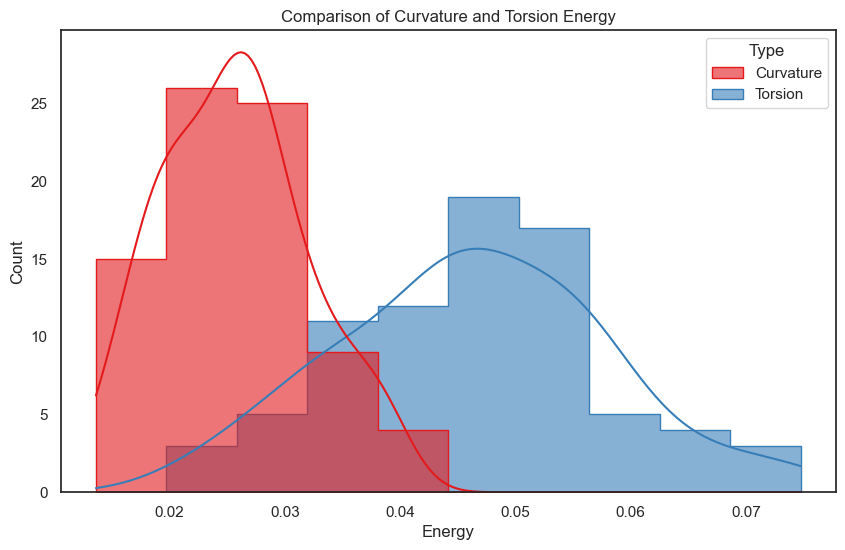

In [394]:
import pandas as pd

def compute_geometry_param_energy(curvature, POWER_ENG_CURVATURE=2):
    curvature_energy = np.mean(np.power(curvature, POWER_ENG_CURVATURE))
    return curvature_energy

curvature_energy = []
torsion_energy = []
# for i in range(len(curvatures)):
#     c = curvatures[i]
#     t = torsions[i]
#     torsion_energy.append(compute_geometry_param_energy(t))
#     curvature_energy.append(compute_geometry_param_energy(c))
curvature_energy = [compute_geometry_param_energy(c) for c in curvatures]
torsion_energy = [compute_geometry_param_energy(t) for t in torsions]

# 创建 DataFrame
df = pd.DataFrame({
    'Energy': curvature_energy + torsion_energy,
    'Type': ['Curvature']*len(curvature_energy) + ['Torsion']*len(torsion_energy)
})

# 绘制堆叠直方图
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Energy', hue='Type', element='step', stat='count', common_bins=True, common_norm=False, alpha=0.6, bins=10, kde=True, palette='Set1')
plt.title('Comparison of Curvature and Torsion Energy')
plt.xlabel('Energy')
plt.ylabel('Count')
plt.show()

Given a series of curvature measurements along the internal carotid artery (ICA) centerline, denoted as \( \mathbf{c} = \{c_1, c_2, \ldots, c_n\} \), the initial step involves computing the cumulative sum \( S \) to expedite subsequent subarray summation calculations. Here, \( S_i \) represents the cumulative sum of the first \( i \) elements:
\[
S_i = \sum_{k=1}^i c_k
\]
with \( S_0 = 0 \) defined to simplify the handling of boundary conditions.

\subsection*{Calculation of Subarray Means}
For each possible subarray length \( l \) (ranging from 1 to \( n \)), we traverse all feasible starting positions \( j \) (ranging from 1 to \( n-l+1 \)) to compute the mean \( \mu \) of the subarray \( \mathbf{c}_{j:j+l-1} \):
\[
\mu = \frac{S_{j+l-1} - S_{j-1}}{l}
\]

\subsection*{Identification of the Longest Maximum Mean Subarray}
For every length \( l \), we record the starting \( j \) and ending position \( j+l-1 \) of the subarray that exhibits the highest mean \( \mu \). In cases where multiple positions yield the same mean value, the subarray closest to the start of the array is selected.

\subsection*{Algorithm Complexity}
The computational complexity of this method is \( O(n^2) \), where \( n \) represents the number of curvature data points. This quadratic complexity arises from the necessity to calculate the mean for all possible subarrays for every potential length.

\subsection*{Implementation Details}
A dynamic programming strategy was employed by precomputing cumulative sums, allowing constant time complexity for any subarray sum computation in subsequent steps. This approach significantly reduces the need for redundant calculations and optimizes the process of mean calculation.

Moreover, while the algorithm efficiently handles datasets with thousands of data points despite its quadratic computational complexity, future work may focus on further optimization or exploration of more efficient algorithms to manage larger datasets.

Through this method, we can determine the segment with the highest average curvature for each possible subarray length, providing a foundation for more detailed analysis and pattern recognition in the curvature data of the ICA. This approach is particularly useful in locating the siphon, a critical region known for its high curvature, thereby aiding in the accurate diagnosis and treatment planning in cerebrovascular care.


max elbow:  32
min elbow:  17
mean elbow:  22.126582278481013


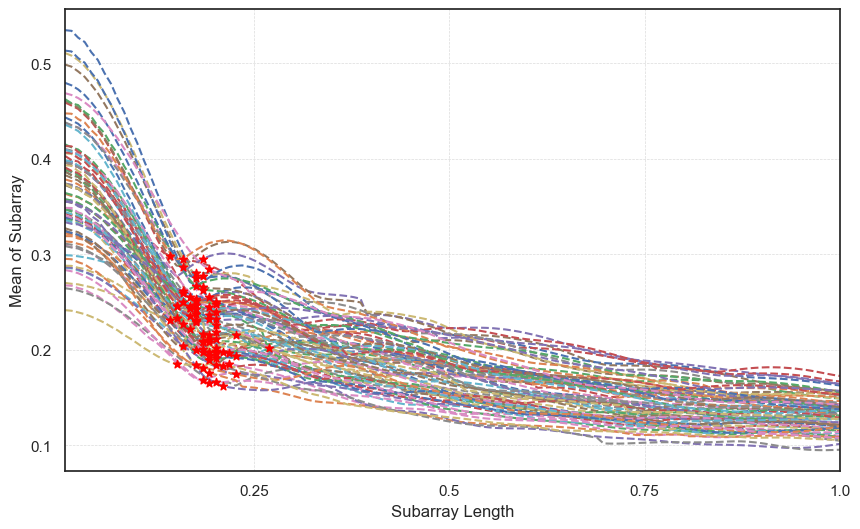

In [395]:
def find_longest_max_mean_subarray(curvature):
    """
    Find the longest subarray with the maximum mean for each possible subarray length.

    Parameters:
    - curvature: A 1D numpy array containing the curvature values.

    Returns:
    - A list of tuples, each containing the subarray and the start and end indices
      for the maximum mean subarray of each possible length.
    """
    n = len(curvature)
    max_subarrays = []

    # Precompute the cumulative sum of curvatures
    cumulative_sum = np.cumsum(curvature)
    cumulative_sum = np.insert(cumulative_sum, 0, 0)  # Insert 0 at the beginning for correct subarray sums

    # Iterate over all possible subarray lengths
    for l in range(1, n + 1):
        max_mean = float('-inf')
        max_start = 0
        max_end = l - 1  # Initialize to the first subarray of length l
        
        # Iterate over all possible start indices for subarrays of length l
        for start in range(0, n - l + 1):
            end = start + l - 1
            # subarray_sum = cumulative_sum[end + 1] - cumulative_sum[start]
            # cur_mean = subarray_sum / l
            cur_mean = compute_geometry_param_energy(curvature[start:end + 1])
            
            # Update if we find a new maximum mean for the current length
            if cur_mean > max_mean or (cur_mean == max_mean and (end - start) > (max_end - max_start)):
                max_mean = cur_mean
                max_start, max_end = start, end
        
        # Store the best subarray for the current length
        max_subarrays.append((curvature[max_start:max_end + 1], (max_start, max_end)))
    
    return max_subarrays

def find_elbow_point(x, y, start_index):
    """
    A heuristic to find the elbow point in a curve starting from a given index.

    Parameters:
    - x: The x-coordinates of the data points.
    - y: The y-coordinates of the data points.
    - start_index: The index in the sequence from which to start looking for the elbow.

    Returns:
    - The x-coordinate of the identified elbow point, if any.
    """
    if start_index >= len(x):
        raise ValueError("start_index is out of the bounds of the data array")

    # Calculate differences between consecutive y-values
    diffs = np.diff(y)
    # Define a threshold as a percentage of the maximum y-value
    threshold = 0.01 * np.max(y)

    # Look for the elbow starting from the specified index
    for i in range(start_index, len(diffs)):
        if abs(diffs[i]) < threshold and (i == start_index or abs(diffs[i - 1]) >= threshold):
            # print("x[i + 1]: ", x[i + 1])
            return x[i + 1]  # Return x corresponding to the found elbow point
            

    return x[-1]  # Return the last point if no clear elbow is found after start_index


def plot_length_vs_mean_multiple(curvatures, ax=None):
    elbows = []
    if ax is None:
        ax = plt.gca()  # 获取当前轴，如果没有传入ax

    for i, curvature in enumerate(curvatures):
        max_subarrays = find_longest_max_mean_subarray(curvature)
        lengths = []
        means = []

        for subarray, (start_index, end_index) in max_subarrays:
            lengths.append(end_index - start_index + 1)
            means.append(np.mean(subarray))

        # 使用Seaborn绘制主线图
        sns.lineplot(x=lengths, y=means, linestyle='--',  ax=ax)
        
        # 确定并标记肘点
        elbow_x = find_elbow_point(lengths, means, 15)
        elbows.append(elbow_x)
        elbow_y = np.interp(elbow_x, lengths, means)  # 插值找到肘点的y值
        ax.scatter(elbow_x, elbow_y, color='red', zorder=5, marker="*")  # 用红星标记肘点
        
    # 打印肘点统计信息
    print("max elbow: ", max(elbows))
    print("min elbow: ", min(elbows))
    print("mean elbow: ", np.mean(elbows))

    # ax.legend()  # 确保图例显示

fig = plt.figure(figsize=(10, 6), dpi=100)
ax = fig.add_subplot(111)
plot_length_vs_mean_multiple(curvatures,ax)
ax.set_xlabel('Subarray Length')
ax.set_ylabel('Mean of Subarray')
# plt.title('Relationship between Subarray Length and Mean Curvature for Multiple Profiles')
ax.grid(linestyle='--', linewidth=0.5, alpha=0.7)

ax.set_xticks(np.linspace(0, len(autocovariance_values), num=5))  # 在0到199之间平均放置5个刻度
# 设置横轴的刻度标签，将其转换为百分比
ax.set_xticklabels(['{}'.format(x) for x in np.linspace(0, 1, num=5)])
ax.autoscale(enable=True, axis='x', tight=True)
# plt.legend()
plt.show()

In [396]:
def identify_siphon_segment(curvature):
    max_subarrays = find_longest_max_mean_subarray(curvature)
    lengths = [end - start + 1 for _, (start, end) in max_subarrays]
    means = [np.mean(subarray) for subarray, _ in max_subarrays]

    # Determine the elbow point, starting from a reasonable index to skip initial fluctuations
    elbow_length = find_elbow_point(lengths, means, 5)
    elbow_index = lengths.index(elbow_length)
    max_subarray, (start_index, end_index) = max_subarrays[elbow_index]

    return max_subarray, (start_index, end_index)


# fig = plt.figure(figsize=(10, 3), dpi=100)
# ax = fig.add_subplot(111)
# ax.autoscale(enable=True, axis='x', tight=True)

# Store a color palette with enough colors for all profiles
palette = sns.color_palette("hls", len(curvatures))

siphon_max_curvatures = []
siphon_mean_curvatures = []
siphon_length = []
siphon_ranges = []


for i, curvature in enumerate(curvatures):
    # Calculate max subarrays and siphon segment first
    max_subarrays = find_longest_max_mean_subarray(curvature)
    siphon_segment, (start, end) = identify_siphon_segment(curvature)
    siphon_length.append(len(siphon_segment))
    siphon_max_curvatures.append(max(curvature[start:end + 1]))
    siphon_mean_curvatures.append(np.mean(curvature[start:end + 1]))
    x_range = range(start, end + 1)
    siphon_ranges.append((start, end))

    # Plot the curvature profile
    
    # sns.lineplot(x=range(len(curvature)), y=curvature, linestyle=':', ax=ax,  color=palette[i])

    # Plot the siphon segment
    # sns.lineplot(x=x_range, y=siphon_segment, linewidth=6, alpha=0.7, ax=ax,  color=palette[i])
    l = np.argmax(curvature)
    n = files[i].split('\\')[-1]
    # ax.annotate(n, (l, curvature[l]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=6)
    is_siphon = np.zeros(len(curvature),dtype=int)
    is_siphon[x_range] = 1
    makeVtkFile('../is_Siphon/'+n+'.vtk',curve_cs[i],[['isSiphon', 'int', is_siphon]])
    

# ax.set_xlabel('Index')
# ax.set_ylabel('Curvature Value')
# plt.title('Curvature Profiles with Identified Siphon Segments')
# plt.show()

siphon_max_curvatures = np.array(siphon_max_curvatures)
siphon_mean_curvatures = np.array(siphon_mean_curvatures)
siphon_length = np.array(siphon_length)



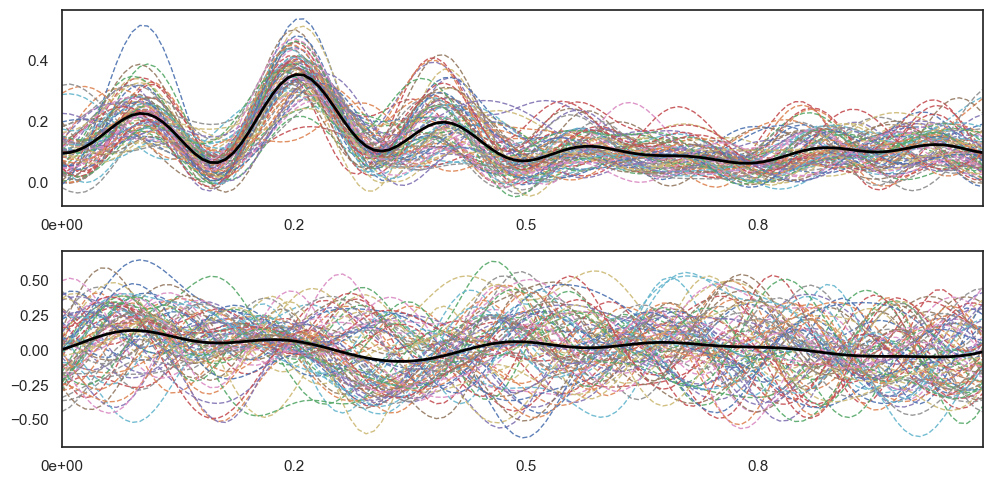

30.323767935121637
9.916273462204067


In [397]:
# 假设 curvatures 是已定义的，每个元素的长度为120
# siphon_ranges 为每个curvatures中siphon段的起始和结束索引列表
from scipy.stats import norm

fig = plt.figure(figsize=(10, 5), dpi=100)
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 2])

ax1 = fig.add_subplot(gs[0, 0])  # 第一行，第一列
ax2 = fig.add_subplot(gs[1, 0])  # 第二行，第一列
# ax3 = fig.add_subplot(gs[2, 0])  # 第三行，第一列 (用于绘制KDE)

# 绘制curvatures和torsions的线图
for i in range(len(curvatures)):
    sns.lineplot(x=np.arange(len(curvatures[i])), y=curvatures[i], ax=ax1, alpha=0.9, linestyle='--', linewidth=1)
    sns.lineplot(x=np.arange(len(torsions[i])), y=torsions[i], ax=ax2, alpha=0.9, linestyle='--', linewidth=1)

sns.lineplot(x=np.arange(len(np.mean(curvatures, axis=0))), y=np.mean(curvatures, axis=0), ax=ax1, color='black', linewidth=2)
sns.lineplot(x=np.arange(len(np.mean(torsions, axis=0))), y=np.mean(torsions, axis=0), ax=ax2, color='black', linewidth=2)

# 计算siphon的位置频率
siphon_probability = np.zeros(120)  # 假设每个curvature的长度都是120
for start, end in siphon_ranges:
    siphon_probability[start:end] += 1

siphon_probability /= len(curvatures)

# 绘制siphon位置的概率
# ax3.fill_between(range(120), siphon_probability, color="skyblue", alpha=0.4)



# 计算siphon位置概率的均值和标准差
mean_siphon = np.dot(np.arange(120), siphon_probability) / np.sum(siphon_probability)
std_siphon = np.sqrt(np.dot(siphon_probability, (np.arange(120) - mean_siphon)**2) / np.sum(siphon_probability))

# 生成高斯分布的数据点
x_values = np.linspace(0, 119, 120)  # 生成与siphon_probability相同长度的x值数组
fitted_pdf = norm.pdf(x_values, mean_siphon, std_siphon)  # 高斯PDF

# 将高斯分布归一化以匹配siphon_probability的比例
scale_factor = np.max(siphon_probability) / np.max(fitted_pdf)
fitted_pdf *= scale_factor

# # 绘制原始概率分布
# ax3.fill_between(range(120), siphon_probability, color="skyblue", alpha=0.4)

# # 绘制高斯拟合曲线
# ax3.plot(x_values, fitted_pdf, ':', linewidth=2, label='Gaussian Fit',color="dimgray")


ax1.set_xticks(np.linspace(0, len(autocovariance_values), num=5))
ax1.set_xticklabels(['{:.00}'.format(x) for x in np.linspace(0, 1, num=5)])
ax2.set_xticks(np.linspace(0, len(autocovariance_values), num=5))
ax2.set_xticklabels(['{:.00}'.format(x) for x in np.linspace(0, 1, num=5)])
# ax3.set_xticks(np.linspace(0, len(autocovariance_values), num=5))
# ax3.set_xticklabels(['{:.00}'.format(x) for x in np.linspace(0, 1, num=5)])
# ax3.set_xlabel('Normalized arclength')
ax1.autoscale(enable=True, axis='x', tight=True)
ax2.autoscale(enable=True, axis='x', tight=True)
# ax3.autoscale(enable=True, axis='x', tight=True)
# ax3.autoscale(enable=True, axis='y')
# ax3.set_xlabel('Siphon Range')
# ax3.set_ylabel('Density')
plt.tight_layout()
plt.show()


print (mean_siphon)
print (std_siphon)

In [398]:
def dice_coefficient(a, b, mean_siphon, std_siphon):
    # 定义高斯关键区间
    gaussian_start = max(0, int(mean_siphon - std_siphon))  # 确保区间不会小于0
    gaussian_end = min(119, int(mean_siphon + std_siphon))  # 确保区间不会大于119

    # 计算交集
    intersection_start = max(a, gaussian_start)
    intersection_end = min(b, gaussian_end)
    if intersection_end > intersection_start:
        intersection_size = intersection_end - intersection_start
    else:
        intersection_size = 0

    # 计算并集
    union_start = min(a, gaussian_start)
    union_end = max(b, gaussian_end)
    union_size = union_end - union_start

    # 计算Dice系数
    if union_size == 0:
        return 0  # 避免除以零
    dice = 2 * intersection_size / (b - a + gaussian_end - gaussian_start)

    return dice

for k in np.linspace(1,3,20):
    dice_scores = [dice_coefficient(a, b, mean_siphon, std_siphon*k) for a, b in siphon_ranges]
    print (k, np.mean(dice_scores))



1.0 0.6526115246891488
1.1052631578947367 0.6646152131133327
1.2105263157894737 0.6750248753886309
1.3157894736842106 0.6834191353426022
1.4210526315789473 0.6911757550285897
1.526315789473684 0.6947927536393452
1.631578947368421 0.692454938724835
1.736842105263158 0.684247292932022
1.8421052631578947 0.6706023271619895
1.9473684210526314 0.6557961538116941
2.052631578947368 0.6332045499375445
2.1578947368421053 0.6184267166085451
2.263157894736842 0.6038105026881097
2.3684210526315788 0.588603430364996
2.473684210526316 0.5735764774871903
2.5789473684210527 0.559387350308209
2.6842105263157894 0.5452970374543528
2.789473684210526 0.5319497312863564
2.894736842105263 0.512686913228476
3.0 0.5006387842001087


In [399]:
Eks = []
Ets = []
s_Eks = []
s_Ets = []
for i in range(len(curvatures)):
    c = curvatures[i]
    t = torsions[i]
    siphon_c = c[siphon_ranges[i][0]:siphon_ranges[i][1]]
    siphon_t = t[siphon_ranges[i][0]:siphon_ranges[i][1]]
    Ek, Et = compute_geometry_param_energy(c), compute_geometry_param_energy(t)
    s_Ek, s_Et = compute_geometry_param_energy(siphon_c), compute_geometry_param_energy(siphon_t)
    Eks.append(Ek)
    Ets.append(Et)
    s_Eks.append(s_Ek)
    s_Ets.append(s_Et)

Eks = np.array(Eks)
Ets = np.array(Ets)
s_Eks = np.array(s_Eks)
s_Ets = np.array(s_Ets)

import numpy as np
from scipy.stats import pearsonr

def generate_labels(data_x, data_y):
    mean_x = np.mean(data_x)
    mean_y = np.mean(data_y)
    labels = np.zeros(len(data_x), dtype=int)
    for i in range(len(data_x)):
        if data_x[i] > mean_x and data_y[i] > mean_y:
            labels[i] = 0
        elif data_x[i] > mean_x and data_y[i] < mean_y:
            labels[i] = 0
        elif data_x[i] < mean_x and data_y[i] > mean_y:
            labels[i] = 1
        else:
            labels[i] = 1
    return labels

# 生成Eks和Ets的标注
labels_eks_ets = generate_labels(Eks, Ets)

# 生成s_Eks和s_Ets的标注
labels_s_eks_s_ets = generate_labels(s_Eks, s_Ets)

# 计算两组标注的相关性
correlation, p_value = pearsonr(labels_eks_ets, labels_s_eks_s_ets)

print("Correlation coefficient:", correlation)
print("P-value:", p_value)


Correlation coefficient: 0.5718870346598202
P-value: 3.685718000157737e-08


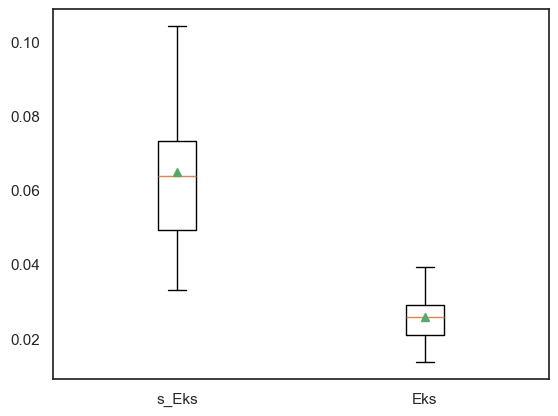

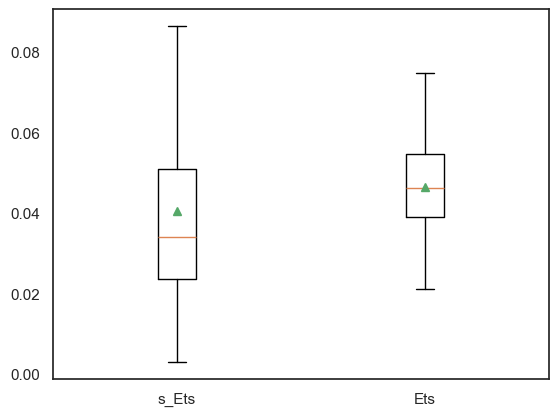

mean: 0.025632673506443493 0.046399450985654574 0.06480819159668817 0.040378309235655836
0:HTHC, 1:HTLC, 2:LTLC, 3:LTLC
0.22784810126582278 0.2911392405063291 0.25316455696202533 0.22784810126582278


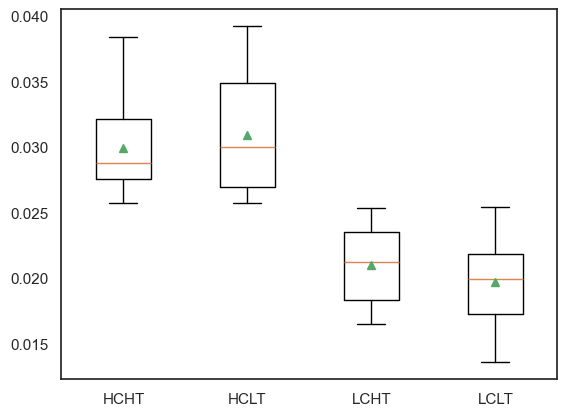

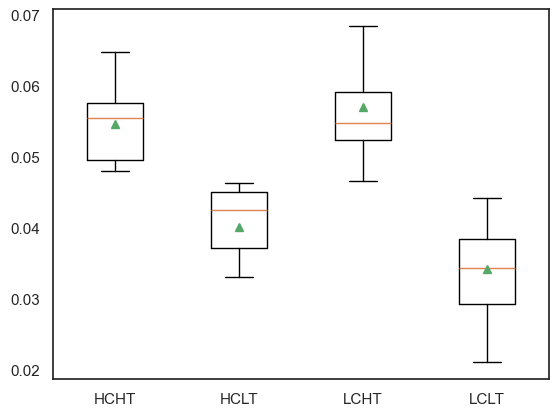

In [400]:
plt.boxplot([s_Eks,Eks], labels=['s_Eks', 'Eks'], showmeans=True, showfliers=False)
plt.show()
plt.boxplot([s_Ets,Ets], labels=['s_Ets', 'Ets'], showmeans=True, showfliers=False)
plt.show()


print ("mean:", np.mean(Eks), np.mean(Ets), np.mean(s_Eks), np.mean(s_Ets))

def count_group(Eks, Ets):
    labels = np.zeros(len(Eks), dtype=int)
    HCHT = []
    HCLT = []
    LCHT = []
    LCLT = []
    for i in range(len(Eks)):
        if Eks[i] > np.mean(Eks) and Ets[i] > np.mean(Ets):
            HCHT.append(i)
            labels[i] = 0
        elif Eks[i] > np.mean(Eks) and Ets[i] < np.mean(Ets):
            HCLT.append(i)
            labels[i] = 1
        elif Eks[i] < np.mean(Eks) and Ets[i] > np.mean(Ets):
            LCHT.append(i)
            labels[i] = 2
        else:
            LCLT.append(i)
            labels[i] = 3
    print (len(HCHT)/len(Eks), len(HCLT)/len(Eks), len(LCHT)/len(Eks), len(LCLT)/len(Eks))
    return labels
print ("0:HTHC, 1:HTLC, 2:LTLC, 3:LTLC")
label = count_group(Eks, Ets)

hcht_Eks = Eks[label==0]
hclt_Eks = Eks[label==1]
lcht_Eks = Eks[label==2]
lclt_Eks = Eks[label==3]

plt.boxplot([hcht_Eks,hclt_Eks,lcht_Eks,lclt_Eks], labels=['HCHT', 'HCLT', 'LCHT', 'LCLT'], showmeans=True, showfliers=False)
plt.show()

hcht_Ets = Ets[label==0]
hclt_Ets = Ets[label==1]
lcht_Ets = Ets[label==2]
lclt_Ets = Ets[label==3]
plt.boxplot([hcht_Ets,hclt_Ets,lcht_Ets,lclt_Ets], labels=['HCHT', 'HCLT', 'LCHT', 'LCLT'], showmeans=True, showfliers=False)
plt.show()

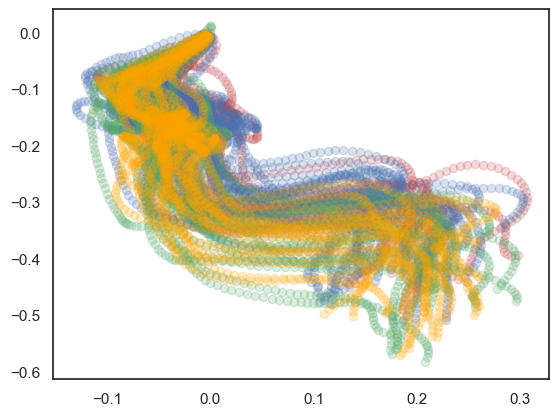

In [401]:
plt.scatter(curve_cs[label==0,:,0],curve_cs[label==0,:,1],c='r', alpha=0.2)
plt.scatter(curve_cs[label==1,:,0],curve_cs[label==1,:,1],c='b', alpha=0.2)
plt.scatter(curve_cs[label==2,:,0],curve_cs[label==2,:,1],c='g', alpha=0.2)
plt.scatter(curve_cs[label==3,:,0],curve_cs[label==3,:,1],c='orange', alpha=0.2)

In [402]:
# 重新排列

g_dist_to_frechet = []
for i in range(len(curve_cs)):
    g_dist_to_frechet.append(curves_r3.metric.dist(mean_estimate, curve_cs[i]))
g_dist_to_frechet = np.array(g_dist_to_frechet)

# 获取按距离从小到大排序的索引
sorted_indices = np.argsort(g_dist_to_frechet)

# 根据这些索引重新排列距离数组
g_dist_to_frechet = g_dist_to_frechet[sorted_indices]

# 对曲率进行相应的从大到小排序

curvatures = curvatures[sorted_indices]
torsions = torsions[sorted_indices]
files = files[sorted_indices]
curve_cs = curve_cs[sorted_indices]

curve_bs = curve_bs[sorted_indices]
label= label[sorted_indices]
Eks = Eks[sorted_indices]
Ets = Ets[sorted_indices]
s_Eks = s_Eks[sorted_indices]
s_Ets = s_Ets[sorted_indices]
amplitude_factors = amplitude_factors[sorted_indices]
phase_shifts = phase_shifts[sorted_indices]



(62, 78) (76, 78)


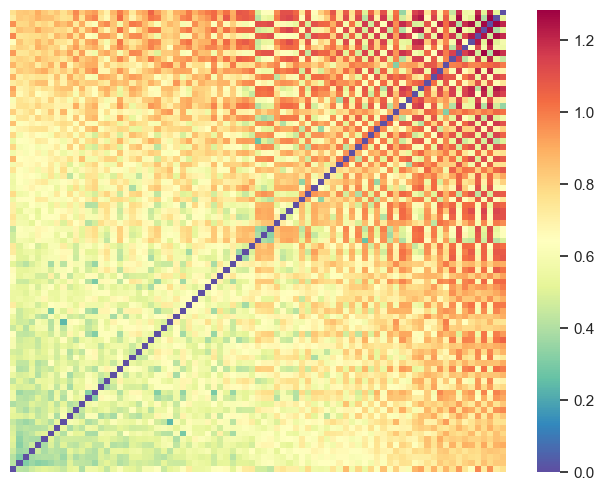

In [403]:
g_dist_min = 100000
g_dist_max = 0
g_dist_min_index = (0,0)
g_dist_max_index = (0,0)
g_dist = []
g_dist_mat = np.zeros((len(curve_bs),len(curve_bs)))
for i in range(len(curve_bs)):
    # geodesic_distance = curves_r3.metric.dist(mean_estimate, curve_bs[i])
    for j in range(len(curve_bs)):
        g_dist_mat[i,j] = curves_r3.metric.dist(curve_bs[i], curve_bs[j])
    
    if i != j and g_dist_mat[i,j] < g_dist_min:
        g_dist_min = g_dist_mat[i,j]
        g_dist_min_index = (i,j)
    elif i != j and g_dist_mat[i,j] > g_dist_max:
        g_dist_max = g_dist_mat[i,j]
        g_dist_max_index = (i,j)
    g_dist.append(g_dist_mat[i,j])
print (g_dist_min_index, g_dist_max_index)
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(111)
sns.heatmap(g_dist_mat,ax=ax, cmap='Spectral_r')
ax.invert_yaxis()
ax.set_xticks([])
ax.set_yticks([])
g_dist_center = np.mean(g_dist_mat, axis=0)

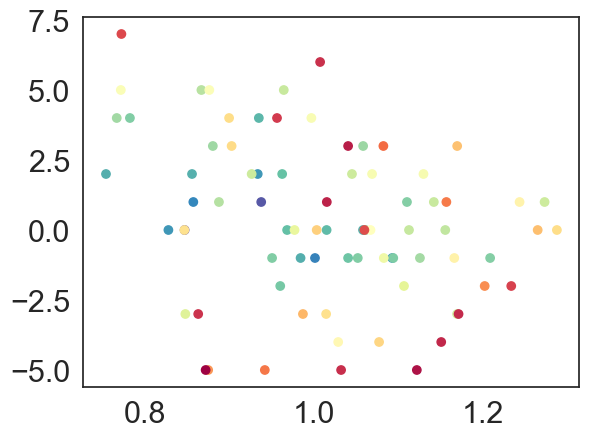

In [416]:
plt.scatter(amplitude_factors, phase_shifts, c=g_dist_center, cmap='Spectral_r')

参考用


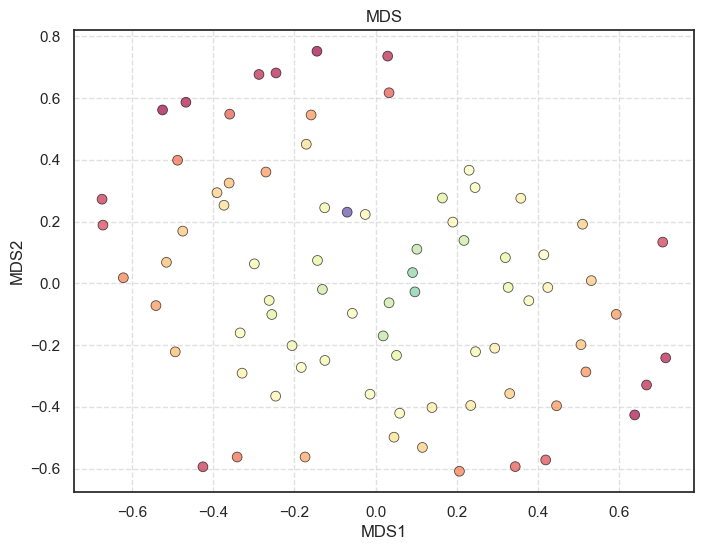

In [404]:
from sklearn.manifold import MDS

print ("参考用")
# 初始化MDS模型，设置降维到2维
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=6)

# 对距离矩阵应用MDS算法
results = mds.fit_transform(g_dist_mat)

# 提取两个维度
x = results[:, 0]
y = results[:, 1]

# 绘制结果
plt.figure(figsize=(8, 6), dpi=100)
sns.scatterplot(x=x, y=y, alpha=0.7,c=g_dist_to_frechet, cmap='Spectral_r', edgecolor='black', s=50)
# plt.plot(x, y, 'k', linewidth=0.5)
# for i in range(len(results)):
#     plt.annotate(i, (x[i], y[i]))
plt.title('MDS')
plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.grid(linestyle='--', alpha=0.6 )
# for i, txt in enumerate(range(1, g_dist_mat.shape[0]+1)):
#     plt.annotate(ruptureStatus[i], (x[i], y[i]))
# plt.savefig(root_dir+'MDS.png')
# plt.close()

[0.54725718 0.22672225 0.08152717 0.03205732]


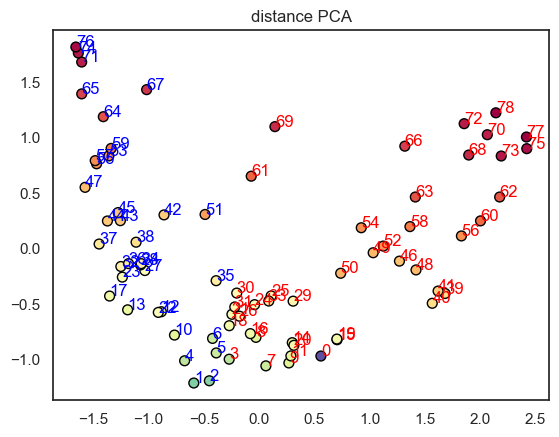

In [405]:
pca_distance = PCA(n_components=4)
pca_distance.fit(g_dist_mat)
pca_distance_result = pca_distance.transform(g_dist_mat)

pca_direction_label = np.zeros(pca_distance_result.shape[0])

for i in range(pca_distance_result.shape[0]):
    if pca_distance_result[i,0] >-0.3:
        textcolor = "red"
        pca_direction_label[i] = 0
    else:
        textcolor = "blue"
        pca_direction_label[i] = 1
    # plt.scatter(pca_distance_result[i,0],pca_distance_result[i,2],c=g_dist_to_frechet[i], marker=marker, cmap='Spectral_r', edgecolor='black', s=50)
    plt.annotate(i, (pca_distance_result[i,0], pca_distance_result[i,1]), color=textcolor, fontsize=12)


plt.scatter(pca_distance_result[:,0],pca_distance_result[:,1],c=g_dist_to_frechet, cmap='Spectral_r', edgecolor='black', s=50)
    
plt.title('distance PCA')
print (pca_distance.explained_variance_ratio_)

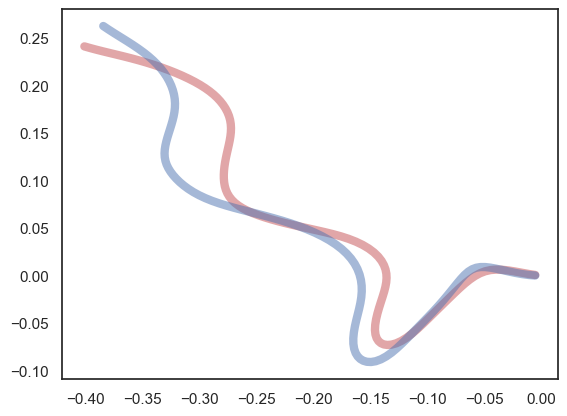

In [406]:
red_curves = mean.fit(curve_cs[pca_direction_label==0])
red_mean_estimate = mean.estimate_
blue_curves = mean.fit(curve_cs[pca_direction_label==1])
blue_mean_estimate = mean.estimate_

plt.plot(red_mean_estimate[:,1],red_mean_estimate[:,2],c='r', linewidth=6, alpha=0.5)
plt.plot(blue_mean_estimate[:,1],blue_mean_estimate[:,2],c='b', linewidth=6, alpha=0.5)


[0.28243925 0.20605652 0.16917278 0.07762821]


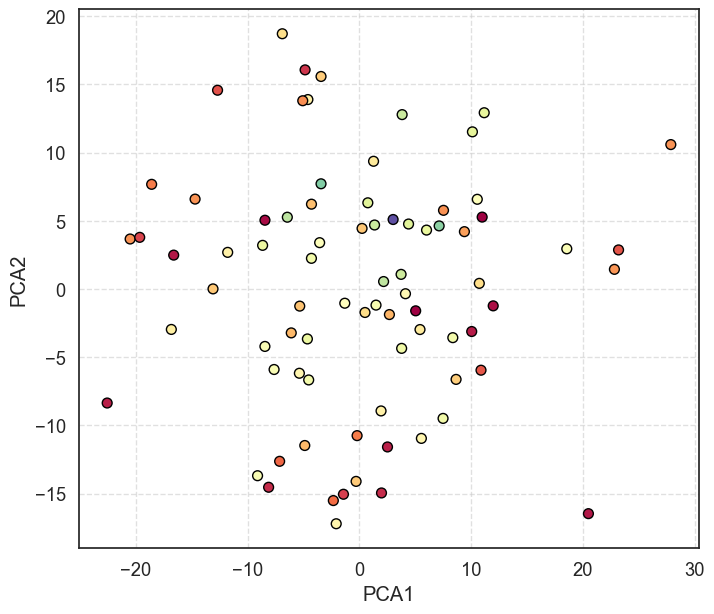

(79,) (79,) (79,)


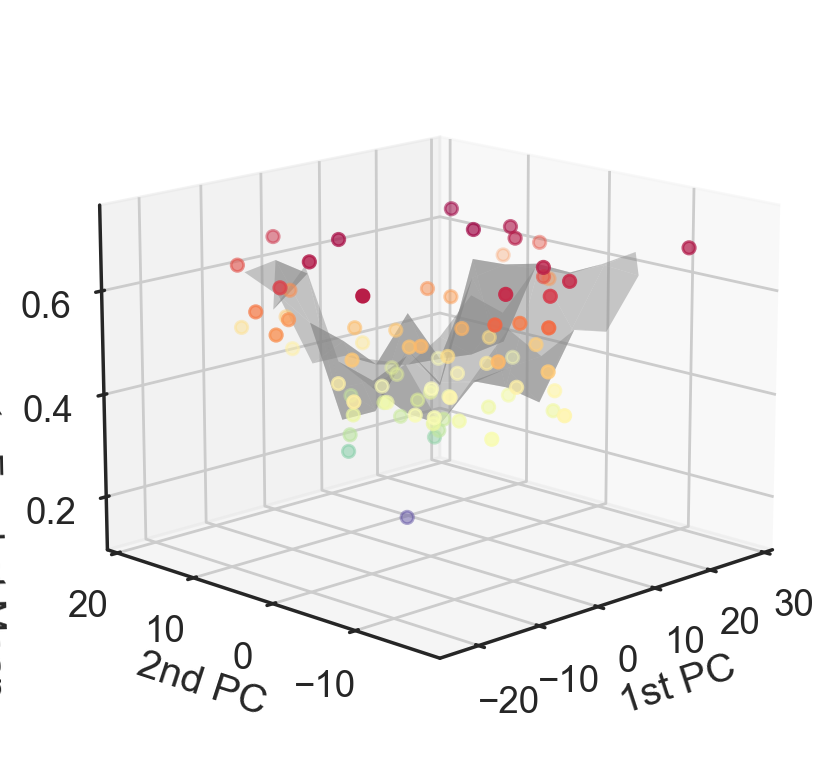

In [407]:

pca = PCA(n_components=4)

standard_coordinate = StandardScaler().fit_transform(curve_cs.reshape(len(curve_cs),-1))
# print (standard_coordinate.shape)
results = pca.fit_transform(standard_coordinate)
print (pca.explained_variance_ratio_)

sns.set_context('notebook', font_scale=1.2)
fig = plt.figure(figsize=(8, 7), dpi=100)
ax = fig.add_subplot(111)
ax.scatter(results[:,0],results[:,1],c=g_dist_to_frechet, cmap='Spectral_r', edgecolor='black', s=50)
ax.grid(linestyle='--', alpha=0.6)
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
plt.show()






# 分解数据到各自的变量
x = results[:, 0]
y = results[:, 1]
z = g_dist_to_frechet
print (x.shape, y.shape, z.shape)


# 创建网格来拟合曲面
grid_x, grid_y = np.mgrid[min(x):max(x):10j, min(y):max(y):10j]
grid_z = griddata((x, y), z, (grid_x, grid_y), method='linear')

# 创建图形和轴
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection='3d')

# 绘制曲面
surf = ax.plot_surface(grid_x, grid_y, grid_z, color='white', edgecolor='none', alpha=0.45)

# 绘制数据点
ax.scatter(x, y, z, c=g_dist_to_frechet, cmap='Spectral_r')

# 添加颜色条
# fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# 设置坐标轴标签
ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_zlabel('Geodesic Distance to Frechet Mean')
ax.view_init(elev=15, azim=45+180) 
# 显示图形
plt.show()


(79, 16)


array([0.39690109, 0.20759248, 0.18275613, 0.07918031, 0.02633007,
       0.02272125, 0.02095439, 0.01317999, 0.01198089, 0.00757386,
       0.00530045, 0.00463232, 0.00343275, 0.00273876, 0.00248908,
       0.00193466])

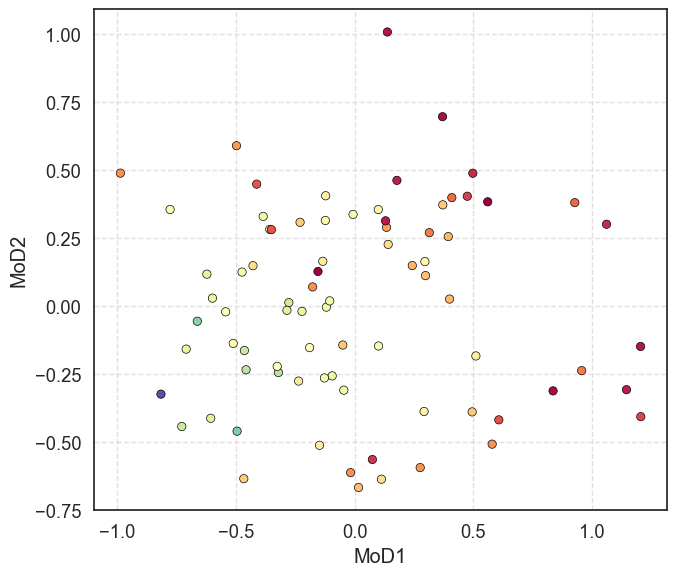

In [408]:
from scipy.ndimage import gaussian_filter
sns.set_context('notebook', font_scale=1.2)
tPCA_N_COMPONENTS = 16

tpca = TangentPCA(curves_r3, n_components=tPCA_N_COMPONENTS)
tpca.fit(curve_cs, base_point=tangent_base)
tangent_projected_data = tpca.transform(curve_cs)

print (tangent_projected_data.shape)
# 步骤4: 分析和可视化结果
sns.set_context('notebook', font_scale=1.2)
fig = plt.figure(figsize=(7, 6))
ax1 = fig.add_subplot(111)
x = tangent_projected_data[:, 0]
y = tangent_projected_data[:, 1]
z = g_dist_to_frechet
grid_x, grid_y = np.mgrid[min(x):max(x):10j, min(y):max(y):10j]
grid_z = griddata((x, y), z, (grid_x, grid_y), method='linear')
grid_z = gaussian_filter(grid_z, sigma=0.07)  # sigma是平滑程度的参数

sns.scatterplot(x=tangent_projected_data[:, 0], y=tangent_projected_data[:, 1], edgecolor='black',c=g_dist_to_frechet,ax=ax1, cmap='Spectral_r')
# contours = plt.contour(grid_x, grid_y, grid_z, levels=10, cmap='Spectral_r', alpha=0.69)
# plt.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')  # 在等高线上添加数值标签

ax1.grid(linestyle='--', alpha=0.6 )
ax1.set_xlabel('MoD1')
ax1.set_ylabel('MoD2')
ax1.autoscale(enable=True, axis='x', tight=False)
plt.tight_layout()
tpca.explained_variance_ratio_

(79,) (79,) (79,)


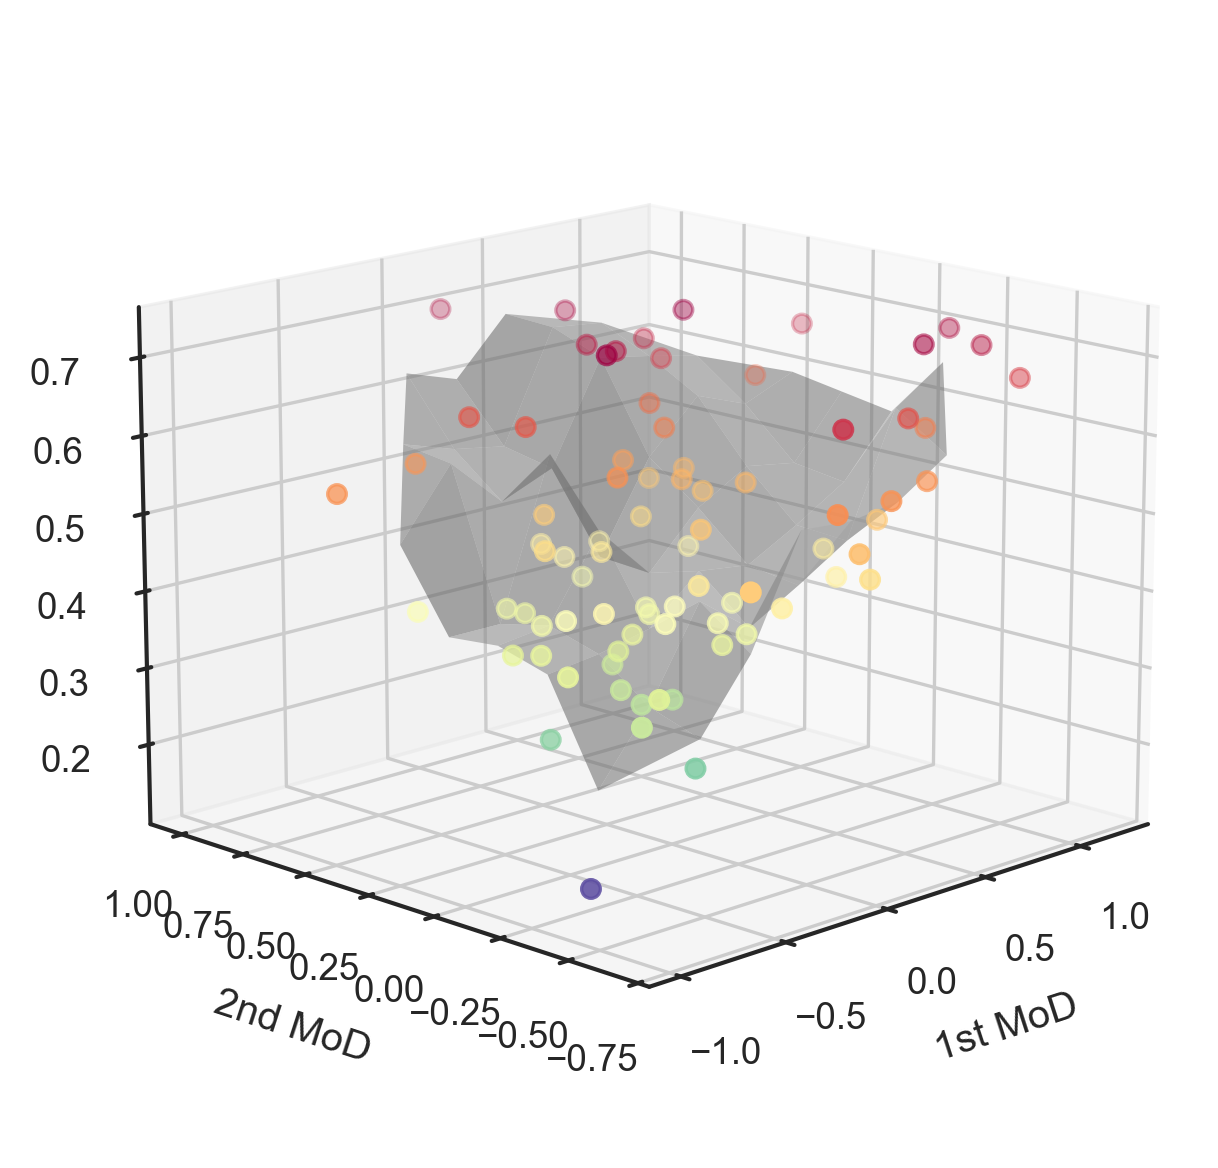

In [409]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata



# 分解数据到各自的变量
x = tangent_projected_data[:, 0]
y = tangent_projected_data[:, 1]
z = g_dist_to_frechet
print (x.shape, y.shape, z.shape)


# 创建网格来拟合曲面
grid_x, grid_y = np.mgrid[min(x):max(x):10j, min(y):max(y):10j]
grid_z = griddata((x, y), z, (grid_x, grid_y), method='linear')

sns.set_context('paper', font_scale=1.0)
# 创建图形和轴
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')

# 绘制曲面
surf = ax.plot_surface(grid_x, grid_y, grid_z, color='white', edgecolor='none', alpha=0.55)

# 绘制数据点
ax.scatter(x, y, z, c=g_dist_to_frechet, cmap='Spectral_r')

# 添加颜色条
# fig.colorbar(surf, ax=ax, shrink=0.85, aspect=15)

ax.set_xlabel('1st MoD')
ax.set_ylabel('2nd MoD')
ax.set_zlabel('Geodesic Distance to Frechet Mean')
ax.view_init(elev=15, azim=45+180) 
# 显示图形
plt.show()


In [410]:
from scipy.stats import norm


def from_tangentPCA_feature_to_curves(tpca, tangent_base, tangent_projected_data, PCA_N_COMPONENTS, discrete_curves_space):
    principal_components = tpca.components_
    # Assuming principal_components has the shape (n_components, n_sampling_points * n_dimensions)
    point_num = len(tangent_base)
    principal_components_reshaped = principal_components.reshape((PCA_N_COMPONENTS, point_num, 3)) # point_num是采样点数
    # Now use exp on each reshaped component
    curves_from_components = [
        discrete_curves_space.metric.exp(tangent_vec=component, base_point=tangent_base)
        for component in principal_components_reshaped
    ]

    reconstructed_curves = []
    for idx in range(len(tangent_projected_data)):
        # This is your feature - a single point in PCA space representing the loadings for the first curve.
        feature = np.array(tangent_projected_data[idx])
        # Reconstruct the tangent vector from the feature.
        # print ("feature:", feature.shape)
        # print ("principal_components_reshaped:", principal_components_reshaped.shape)
        # print ("idx:", idx)
        tangent_vector_reconstructed = sum(feature[i] * principal_components_reshaped[i] for i in range(len(feature)))
        # Map the tangent vector back to the curve space using the exponential map.
        reconstructed_curve = discrete_curves_space.metric.exp(
            tangent_vec=tangent_vector_reconstructed, base_point=tangent_base
        )
        # reconstructed_curve = inverse_srvf(reconstructed_srvf, np.zeros(3))
        # print ("reconstructed_curve length:", measure_length(reconstructed_curve))# length=63
        
        reconstructed_curves.append(reconstructed_curve)
    reconstructed_curves = np.array(reconstructed_curves)
    return reconstructed_curves

discrete_curves_space = curves_r3
print (tPCA_N_COMPONENTS)
reconstructed_curves = from_tangentPCA_feature_to_curves(tpca, tangent_base, tangent_projected_data, 
                                                                              tPCA_N_COMPONENTS, 
                                                                              discrete_curves_space)

total_l2d = []
for curve_idx in range(79):
    l2d = []
    # for i in [1,2,3,5,10,15]:
    for i in range(tPCA_N_COMPONENTS):
        ft = tangent_projected_data[curve_idx,:].copy()
        # print (ft.shape)
        ft[i:] = 0
        reconstructed_step_curve = from_tangentPCA_feature_to_curves(tpca, tangent_base, np.array([ft]), 
                                                                                    tPCA_N_COMPONENTS, 
                                                                                    discrete_curves_space)[0]
        least_squares_error = curves_r3.metric.dist(curve_cs[curve_idx], reconstructed_step_curve)
        l2d.append(least_squares_error)
    total_l2d.append(l2d)


16


(16,)


Text(0, 0.5, 'Error')

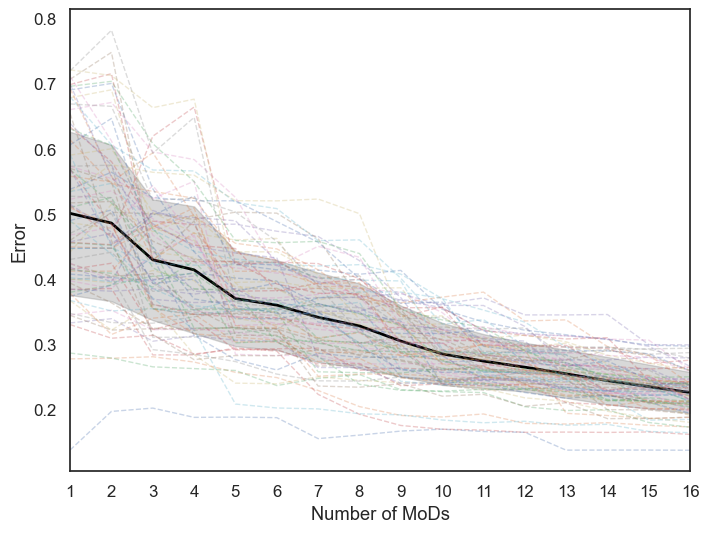

In [411]:
sns.set_context('notebook', font_scale=1.1)

total_l2d = np.array(total_l2d)
mean_l2d = np.mean(total_l2d, axis=0)
std_l2d = np.std(total_l2d, axis=0)
print (np.mean(total_l2d,axis=0).shape)
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(111)
ax .plot(np.mean(total_l2d,axis=0),linestyle='-', color='black', linewidth=2)
# 绘制标准差带
ax.fill_between(range(len(mean_l2d)), mean_l2d - std_l2d, mean_l2d + std_l2d, color='gray', alpha=0.3)
for i in range(79):
    ax.plot(total_l2d[i],linestyle='--', alpha=0.3, linewidth=1)
ax.autoscale(enable=True, axis='x', tight=True)

# 获取当前x轴的刻度位置（默认是从0开始）并加1来变成从1开始
ticks = np.arange(len(mean_l2d))  # 生成从0到len(mean_l2d)-1的整数数组
ax.set_xticks(ticks)  # 设置x轴的刻度位置
ax.set_xticklabels(ticks + 1)  # 设置x轴的刻度标签，从1开始
ax.set_xlabel('Number of MoDs')
ax.set_ylabel('Error')

(16,)
(21, 16)
(3, 7, 16)


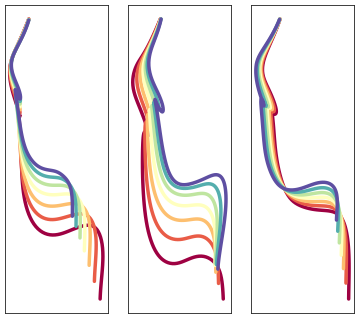

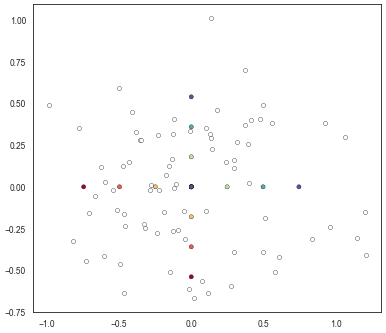

In [412]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors


mean_tangent_projected_data = np.mean(tangent_projected_data, axis=0)
std_tangent_projected_data = np.std(tangent_projected_data, axis=0)
print (mean_tangent_projected_data.shape)

# 生成一个包含所有可能偏移的数据集
atlas_projected_data = []

sigma=np.linspace(-1.5,1.5,7)
for i in range(3):
    for j in sigma:
        a_project_data = mean_tangent_projected_data.copy()
        a_project_data[i] += std_tangent_projected_data[i]*j
        atlas_projected_data.append(a_project_data)
atlas_projected_data = np.array(atlas_projected_data)
print (atlas_projected_data.shape)
atlas_projected_data= atlas_projected_data.reshape(3,7,-1)
print (atlas_projected_data.shape)

num_curves = len(sigma)  # 获取曲线的数量

# 创建颜色映射和标准化对象
cmap = plt.get_cmap('Spectral')
norm = mcolors.Normalize(vmin=0, vmax=num_curves-1)

# 使用 ScalarMappable 来映射颜色
scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure(figsize=(9,8), dpi=50)
axes = fig.subplots(1, 3)

fig_s = plt.figure(figsize=(9,8), dpi=50)
ax_s = fig_s.add_subplot(111)
sns.scatterplot(x=tangent_projected_data[:, 0], y=tangent_projected_data[:, 1], edgecolor='black',c="white",ax=ax_s)
for ax, atlas_projected_d in zip(axes, atlas_projected_data):
    sns.scatterplot(x=atlas_projected_d[:, 0], y=atlas_projected_d[:, 1], edgecolor='black',c=range(len(atlas_projected_d)),cmap=cmap,ax=ax_s)
    atlas_reconstructed_synthetic_curves = from_tangentPCA_feature_to_curves(tpca, tangent_base, atlas_projected_d, 
                                                                                tPCA_N_COMPONENTS, 
                                                                                discrete_curves_space)
        
    # 假设 reconstructed_synthetic_curves 是已定义的曲线数组
    for i in range(len(atlas_reconstructed_synthetic_curves)):
        # 获取当前索引的颜色
        color = scalar_mappable.to_rgba(i)
        # 绘制曲线
        ax.plot(atlas_reconstructed_synthetic_curves[i][:, 0], atlas_reconstructed_synthetic_curves[i][:, 1], linewidth=5, color=color)
        
        # ax.plot(atlas_reconstructed_synthetic_curves[i][:,0],atlas_reconstructed_synthetic_curves[i][:,1], linewidth=5)
    ax.set_xticks([])
    ax.set_yticks([])




In [413]:
print (tangent_projected_data[:, :3].shape)

(79, 3)


In [414]:

import imageio

mean_tangent_projected_data = np.mean(tangent_projected_data, axis=0)
std_tangent_projected_data = np.std(tangent_projected_data, axis=0)
print (mean_tangent_projected_data.shape)

# 生成一个包含所有可能偏移的数据集
atlas_projected_data = []
frame=50
sigma=np.linspace(-2,2,frame)
mods = 3

for i in range(mods):
    for j in sigma:
        a_project_data = mean_tangent_projected_data.copy()
        a_project_data[i] += std_tangent_projected_data[i]*j
        atlas_projected_data.append(a_project_data)
atlas_projected_data = np.array(atlas_projected_data)
print (atlas_projected_data.shape)
atlas_projected_data= atlas_projected_data.reshape(mods,frame,-1)
print (atlas_projected_data.shape)

e_tau_superlist = []
e_kappa_superlist = []
for j, atlas_projected_d in enumerate(atlas_projected_data):
    atlas_centerline_dir = mkdir("./", "{}_atlas_reconstructed_synthetic_curves".format(j))
    
    atlas_reconstructed_synthetic_curves = from_tangentPCA_feature_to_curves(tpca, tangent_base, atlas_projected_d, 
                                                                              tPCA_N_COMPONENTS, 
                                                                              discrete_curves_space)
    fig, ax = plt.subplots(figsize=(4, 8), dpi=100)
    sns.set_context("notebook", font_scale=2)

    # 存储所有图像文件的列表，稍后用于制作GIF
    images = []
    e_tau_list = []
    e_kappa_list = []
    for i, curve in enumerate(atlas_reconstructed_synthetic_curves):
        # 清除当前axes
        ax.clear()

        # 绘制背景点和突出点
        # sns.scatterplot(x=tangent_projected_data[:, 0], y=tangent_projected_data[:, 1], edgecolor='black', color="white", ax=ax, s=90)    
        # sns.scatterplot(x=[atlas_projected_d[i, 0]], y=[atlas_projected_d[i, 1]], color="red", ax=ax, s=90)
        # plt.boxplot(atlas_projected_d, positions=[i], widths=0.6, patch_artist=True, boxprops=dict(facecolor='red'))
        ax.boxplot(tangent_projected_data[:, :3], widths=0.3, patch_artist=True, boxprops=dict(facecolor='none'), vert=True)
        ax.scatter(j+1, atlas_projected_d[i, j], c='red', s=90,marker='^')

        # 计算并处理曲线
        c, t = compute_curvature_and_torsion(curve * 100)
        fft_c = remove_high_freq_components(c, 0.065)
        fft_t = remove_high_freq_components(t, 0.065)
        e_kappa= compute_geometry_param_energy(fft_c)
        e_tau = compute_geometry_param_energy(fft_t)
        e_tau_list.append(e_tau)
        e_kappa_list.append(e_kappa)
        makeVtkFile(atlas_centerline_dir + "Centerline_{:03d}.vtk".format(i), curve, [["Curvature", "float", fft_c]])

        # 绘制曲线
        # ax.plot(curve[:, 0], curve[:, 1], linewidth=5)

        # 保存当前图像到文件，并将其添加到列表中
        ax.set_xlabel("MoDs")
        ax.set_ylabel("Loading")
        plt.tight_layout()
        filename = atlas_centerline_dir + "Centerline_{:03d}.png".format(i)
        plt.savefig(filename)

        images.append(imageio.imread(filename))

    # 制作并保存GIF
    imageio.mimsave('{}_curves_animation.gif'.format(j), images, duration=0.5, loop=0)
    plt.close(fig)
    e_tau_superlist.append(e_tau_list)
    e_kappa_superlist.append(e_kappa_list)
    

(16,)
(150, 16)
(3, 50, 16)


d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)
C:\Users\cheno\AppData\Local\Temp\ipykernel_14480\841269526.py:69: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
d:\!BraVa_src\ica_re

In [415]:
import glob
import imageio

# 设置图片文件所在的目录
directory = './2_atlas_reconstructed_synthetic_curves/animation/'

# 使用glob模块找到所有符合特定模式的文件
file_pattern = directory + 'animation.*.png'
files = sorted(glob.glob(file_pattern))

# 读取图片文件
images = [imageio.imread(file) for file in files]

# 保存图片为GIF动画，无限循环
imageio.mimsave(directory + 'animation.gif', images, duration=0.5, loop=0)


C:\Users\cheno\AppData\Local\Temp\ipykernel_14480\3684278082.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(file) for file in files]
